# NBA STATS ANALYSIS IN PYTHON:
This is my attempt to create a package that can be used to issue requests
to basketball-reference.com and analyze basketball statistics

In [29]:
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Below is a class for aquiring data from basketball-reference.com
### Allows the user to request data by player name and returns a dictionary of different types of statistics

In [56]:
class Data:

    class player:
        
        def __init__(self, player_name):
            self.player_name = player_name
            self._URL = "https://www.basketball-reference.com/players/"
            self.table_types = ['all_per_game', 'all_totals', 'all_per_minute', 'all_per_poss', 
                                'all_advanced', 'all_shooting', 'all_pbp', 'all_year-and-career-highs', 
                                'all_playoffs_per_game', 'all_playoffs_totals', 'all_playoffs_per_minute', 
                                'all_playoffs_per_poss', 'all_playoffs_advanced', 'all_playoffs_shooting', 
                                'all_playoffs_pbp', 'all_year-and-career-highs-po', 'all_all_star', 'all_sim_thru', 
                                'all_sim_career', 'all_all_college_stats', 'all_all_salaries']
            
        
            
        def fetch(self, table_types=["all_per_game"]):
            #flip the player's name (e.g. "Michael Jordan" -> ["Jordan", "Michael"])
            inv_player_name = self.player_name.lower().split(" ")[::-1]
            
            #create an url extension from the player name ("j/jordami01.html")
            player_tag = inv_player_name[0][0]+"/"+inv_player_name[0][0:5]+inv_player_name[1][0:2]+"01.html"

            #create the full url ("https://www.basketball-reference.com/players/j/jordami01.html")
            _FULL_URL = self._URL + player_tag

            #make a request to the page and report status of response
            response = requests.get(_FULL_URL)
            print("<status: "+str(response.status_code)+">")

            #parse the raw html
            soup = bs(response.content, "html.parser")
            
            '''
            Except for per game statistics, all other statistics must be pulled from the comments in the html.
            It is unclear why these statistics cannot be found with soup.findAll("div",{"class":"table_container"})
            without searching the comments.
            '''
            ###################################################################################
            #Pull the comments out of the soup
            comments = soup.findAll(text=lambda text: isinstance(text,Comment))
            
            c_schema = {}
            for c in comments:
                #parse each comment to find commented out html
                c_soup = bs(c, "html.parser")
                
                #get all the table container names
                divs = c_soup.findAll("div",{"class":"table_container"})
            
                for div in divs:
                    #get the name of the table and replace "div" with "all" to match table_types list
                    table_name = str(div.get("id")).replace("div","all")
                    
                    #get a list of unique data columns in the table
                    table_schema = list(set(d.get("data-stat") for d in div.findAll("td")))
                    
                    #create a dictionary from each column and initialize to an empty list
                    c_schema[table_name] = dict((key, []) for key in table_schema)
                    
                    #add each data entry to the list that corresponds to it's data-stat attribute
                    for d in div.findAll("td"):
                        c_schema[table_name][d.get("data-stat")] += [str(d.string)]
                    
            #create a dictionary to hold all the different stat tables
            all_dfs = {}
            
            #convert each dictionary to pandas Dataframe
            for c_t in c_schema.keys():
                all_dfs[c_t] = pd.DataFrame.from_dict(c_schema[c_t])
            ###################################################################################
            
            
            #find all the tables
            tables = soup.findAll("div", {"class": "table_wrapper"})
            
            #map an index to each table type
            table_map = {}
            for num, key in enumerate([t.get("id") for t in tables]):
                table_map[key] = num       
            
            
            for t in table_types:
                #find the schema for the data table
                schema = list(set([d.get("data-stat") for d in tables[table_map[t]].findAll("td")]))
                
                #initialize a dictionary of empty lists mapped to the schema
                stats = {}
                for s in schema:
                    stats[s] = []

                #add the data from each tag to the appropriate list
                for d in tables[table_map[t]].findAll("td"):
                    if str(d.string)[0].isdigit() or str(d.string)[0] == ".":
                        value = float(d.string) 
                    else:
                        value = d.string

                    stats[d.get("data-stat")].append(value)

                    
                #create a dataframe from data, dropping rows where data has been aggregated (i.e. only return raw data)
                if "age" in stats.keys():
                    stats_df = pd.DataFrame.from_dict(stats).dropna(subset=["age"])
                    
                elif "pos" in stats.keys():
                    stats_df = pd.DataFrame.from_dict(stats).dropna(subset=["pos"])
                    
                else:
                    stats_df = pd.DataFrame.from_dict(stats)
                    
                all_dfs[t] = stats_df
            
            #return dataframe
            return all_dfs

In [57]:
KP = Data.player("Kristaps Porzingis").fetch()#table_types=['all_advanced'])#["all_advanced"].query("team_id != 'TOT'")

<status: 200>


## Ever wondered how the Warriors shooting numbers compare in terms of points per shot on 2 pointers vs points per shot on 3 pointers?

Stephen Curry:
<status: 200>
Kevin Durant:
<status: 200>
Klay Thompson:
<status: 200>
Draymond Green:
<status: 200>
Andre Iguodala:
<status: 200>
Demarcus Cousins:
<status: 200>


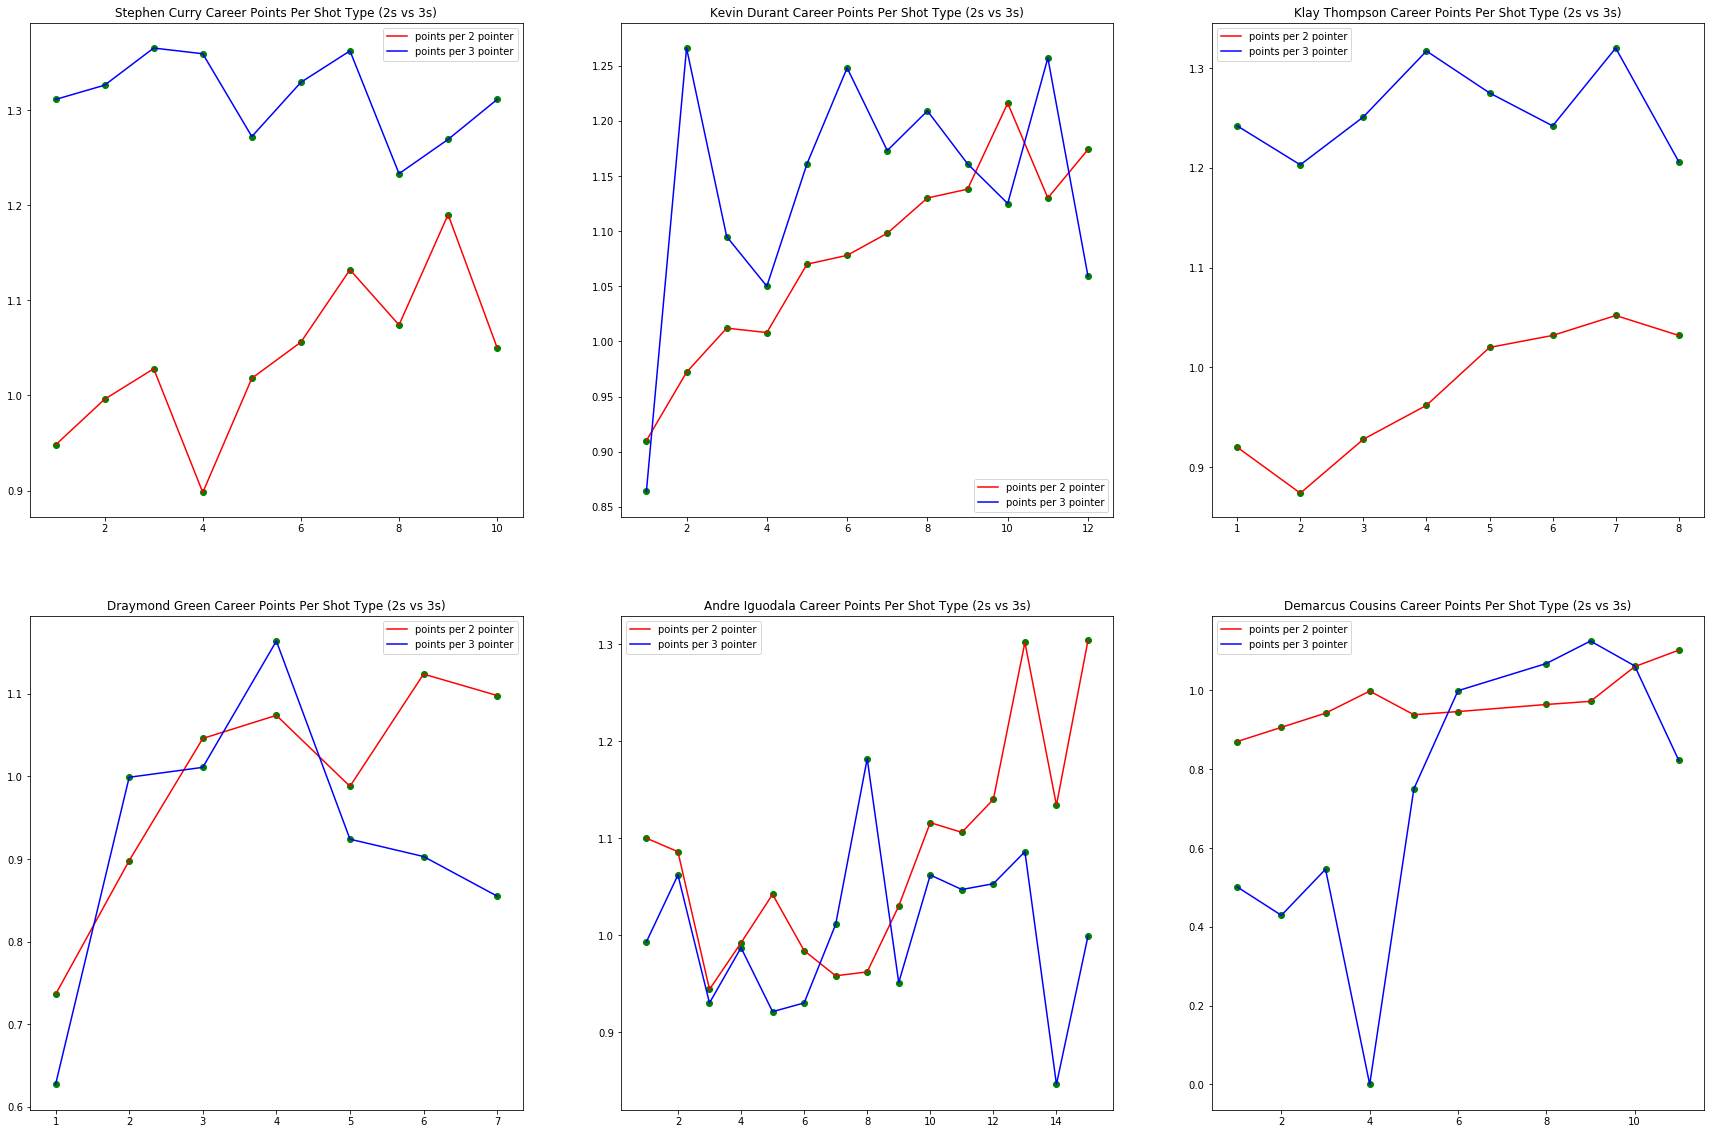

In [60]:
warriors = ["Stephen Curry","Kevin Durant","Klay Thompson","Draymond Green", "Andre Iguodala", "Demarcus Cousins"]

plt.figure(figsize=(30, 20))
for count, warrior in enumerate(warriors):
    print(warrior+":")
    player = Data.player(warrior).fetch()["all_per_game"].query("team_id != 'TOT'")
    
    years = player.index + 1
    
    pct_3s = player["fg3_pct"].values * 3.0
    pct_2s = player["fg2_pct"].values * 2.0
    
    plt.subplot(2,3,count+1)
    plt.plot(years, pct_2s, c="r", label="points per 2 pointer")
    plt.scatter(years,pct_2s,c="g")
    plt.plot(years, pct_3s, c="b", label="points per 3 pointer")
    plt.scatter(years,pct_3s,c="g")


    plt.title("{} Career Points Per Shot Type (2s vs 3s)".format(warrior))
    plt.legend()


# Maybe you're curious how Mitch Robinson's rookie year compared to Patrick Ewing's Career

In [64]:
Ewing = Data.player("Patrick Ewing").fetch()["all_per_game"].query("team_id != 'TOT'")
Ewing

<status: 200>


,ast_per_g,fg2_pct,pts_per_g,drb_per_g,g,trb_per_g,tov_per_g,fg_per_g,age,pf_per_g,...,fg2a_per_g,fg3_per_g,pos,blk_per_g,fta_per_g,lg_id,gs,team_id,stl_per_g,efg_pct
0,2.0,0.477,20.0,6.5,50.0,9.0,3.4,7.7,23.0,3.8,...,16.2,0.0,C,2.1,6.1,NBA,50.0,NYK,1.1,0.474
1,1.7,0.507,21.5,6.3,63.0,8.8,3.6,8.4,24.0,3.9,...,16.6,0.0,PF,2.3,6.6,NBA,63.0,NYK,1.4,0.503
2,1.5,0.556,20.2,5.3,82.0,8.2,3.5,8.0,25.0,4.0,...,14.4,0.0,C,3.0,5.8,NBA,82.0,NYK,1.3,0.555
3,2.4,0.570,22.7,6.6,80.0,9.3,3.3,9.1,26.0,3.9,...,16.0,0.0,C,3.5,6.1,NBA,80.0,NYK,1.5,0.567
4,2.2,0.552,28.6,8.0,82.0,10.9,3.4,11.2,27.0,4.0,...,20.4,0.0,C,4.0,7.9,NBA,82.0,NYK,1.0,0.551
5,3.0,0.516,26.6,8.8,81.0,11.2,3.6,10.4,28.0,3.5,...,20.2,0.0,C,3.2,7.7,NBA,81.0,NYK,1.0,0.514
6,1.9,0.523,24.0,8.5,82.0,11.2,2.5,9.7,29.0,3.4,...,18.5,0.0,C,3.0,6.2,NBA,82.0,NYK,1.1,0.522
7,1.9,0.504,24.2,9.7,81.0,12.1,3.3,9.6,30.0,3.5,...,19.0,0.0,C,2.0,6.9,NBA,81.0,NYK,0.9,0.503
8,2.3,0.498,24.5,8.4,79.0,11.2,3.3,9.4,31.0,3.5,...,18.8,0.1,C,2.7,7.4,NBA,79.0,NYK,1.1,0.497
9,2.7,0.506,23.9,9.0,79.0,11.0,3.2,9.2,32.0,3.4,...,18.1,0.1,C,2.0,7.1,NBA,79.0,NYK,0.9,0.505


In [77]:
Mitch = Data.player("Mitchell Robinson").fetch()["all_per_game"].query("team_id != 'TOT'")
Mitch

<status: 200>


,ast_per_g,fg2_pct,pts_per_g,drb_per_g,g,trb_per_g,tov_per_g,fg_per_g,age,pf_per_g,...,fg2a_per_g,fg3_per_g,pos,blk_per_g,fta_per_g,lg_id,gs,team_id,stl_per_g,efg_pct
0,0.6,0.694,7.3,3.7,66.0,6.4,0.5,3.1,20.0,3.3,...,4.4,0.0,C,2.4,2.0,NBA,19.0,NYK,0.8,0.694


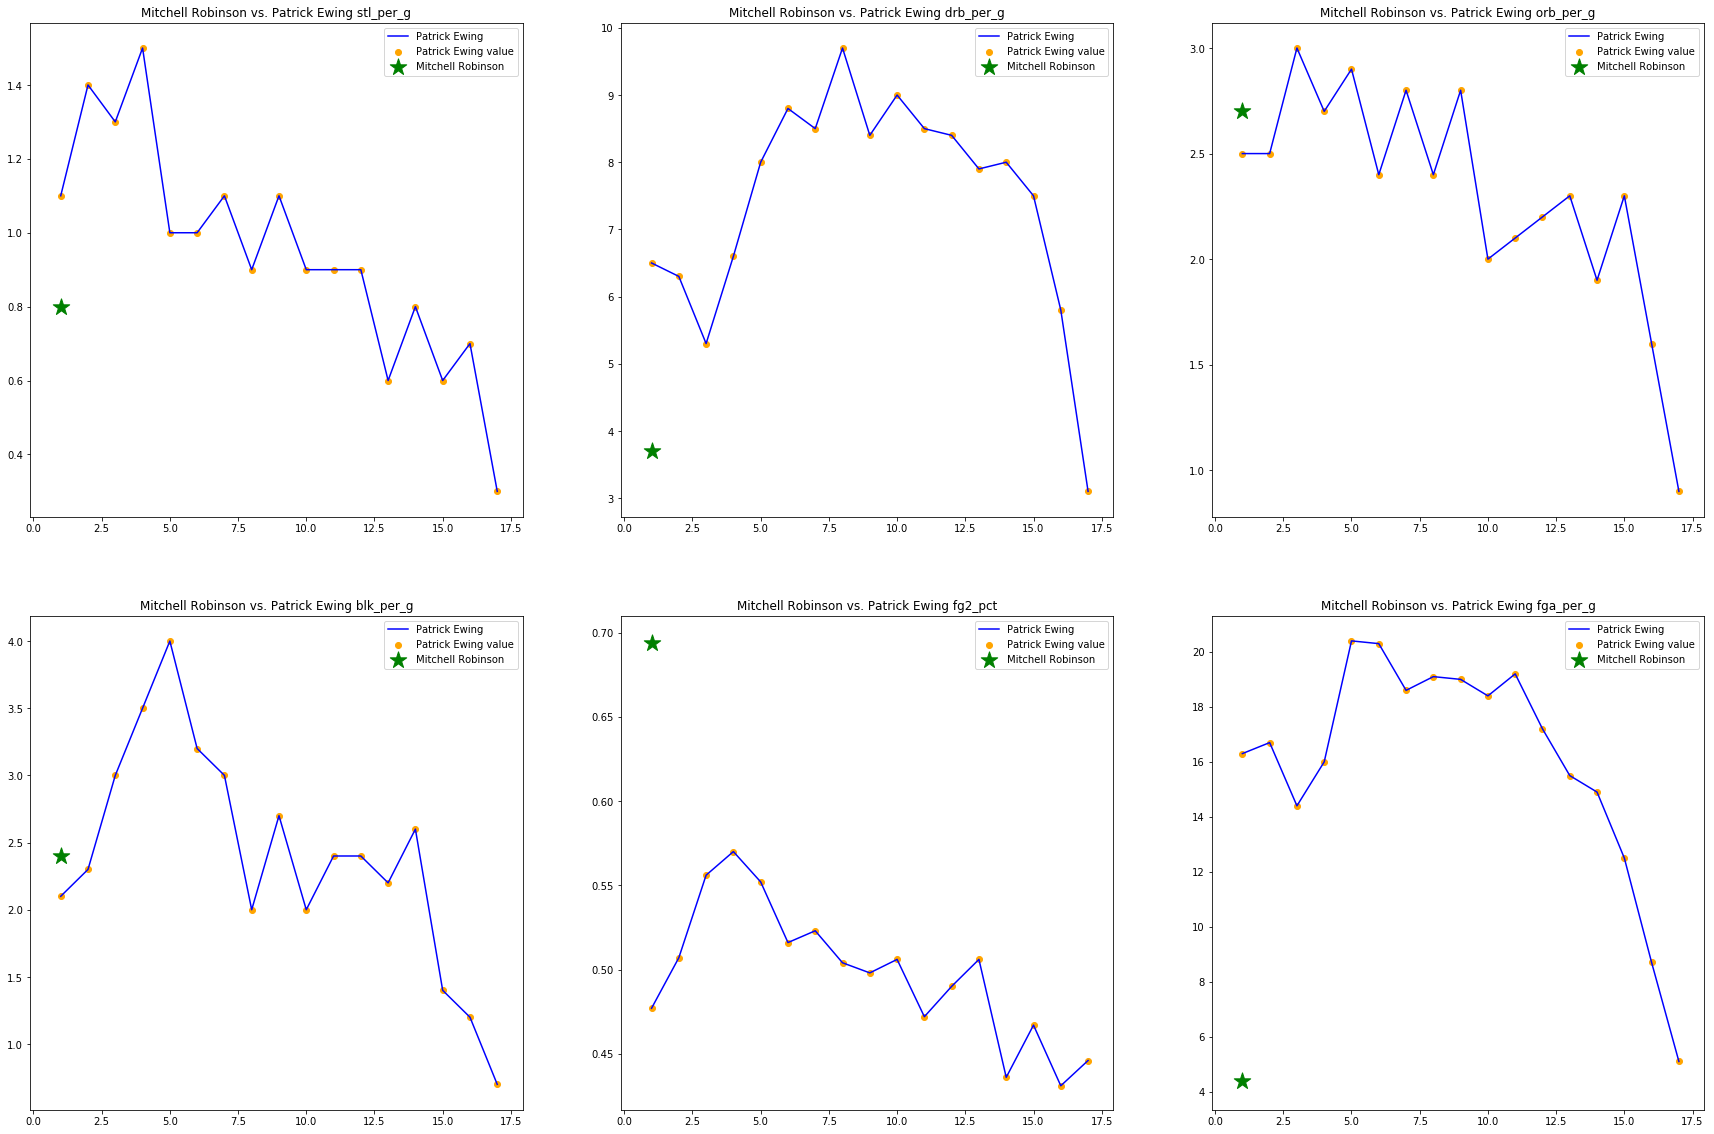

In [67]:
big_stats = ['stl_per_g',"drb_per_g",'orb_per_g','blk_per_g','fg2_pct','fga_per_g']

plt.figure(figsize=(30,20))
for count, stat in enumerate(big_stats):
    Mitch_years = Mitch.index + 1
    Ewing_years = Ewing.index + 1
    
    plt.subplot(2,3,count+1)
    plt.plot(Ewing_years, Ewing[stat],c="b", label="Patrick Ewing")
    plt.scatter(Ewing_years, Ewing[stat],c="orange",label="Patrick Ewing value")
    plt.scatter(Mitch_years, Mitch[stat],c="g", marker="*", s=300, label="Mitchell Robinson")
    
    plt.title("Mitchell Robinson vs. Patrick Ewing {}".format(stat))
    plt.legend()

# How has Kristap's Porzingis' shooting breakdown developed over his career? Is he assuming Carmelo Anthony's title as king of the mid-range?

In [95]:
KP = Data.player("Kristaps Porzingis").fetch()["all_shooting"].query("age != 'None'")
Me7o = Data.player("Carmelo Anthony").fetch()["all_shooting"].query("age != 'None'")

<status: 200>
<status: 200>


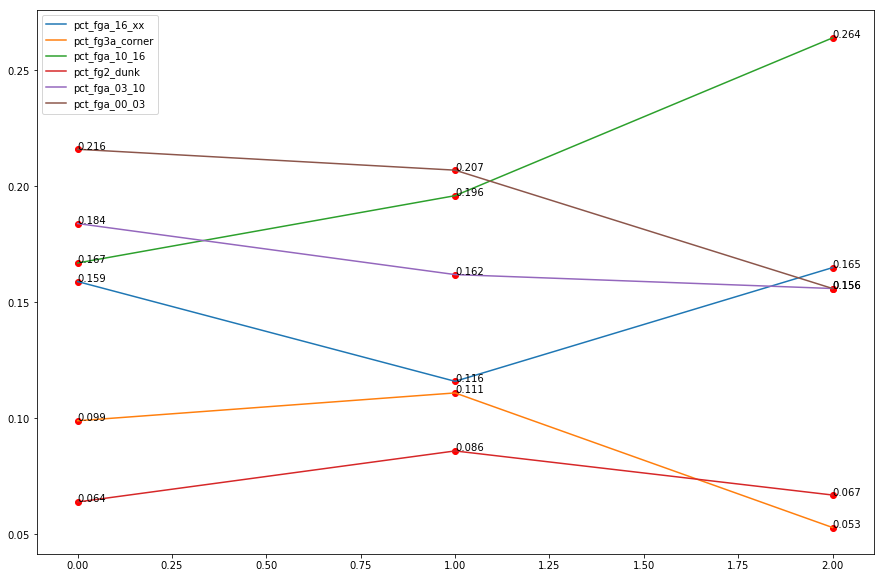

In [163]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for key in KP.keys():
    index = KP.index
    if key[0:3] == "pct":
        vals = list(map(lambda x: float(x), KP[key].values))
        i = list(map(lambda x: int(x), index))
        plt.plot(i,vals,label = key)
        plt.scatter(i,vals,color="#ff0000")
        
        for v in range(len(vals)):
            plt.annotate(vals[v],(i[v],vals[v]))
        

        
plt.legend()

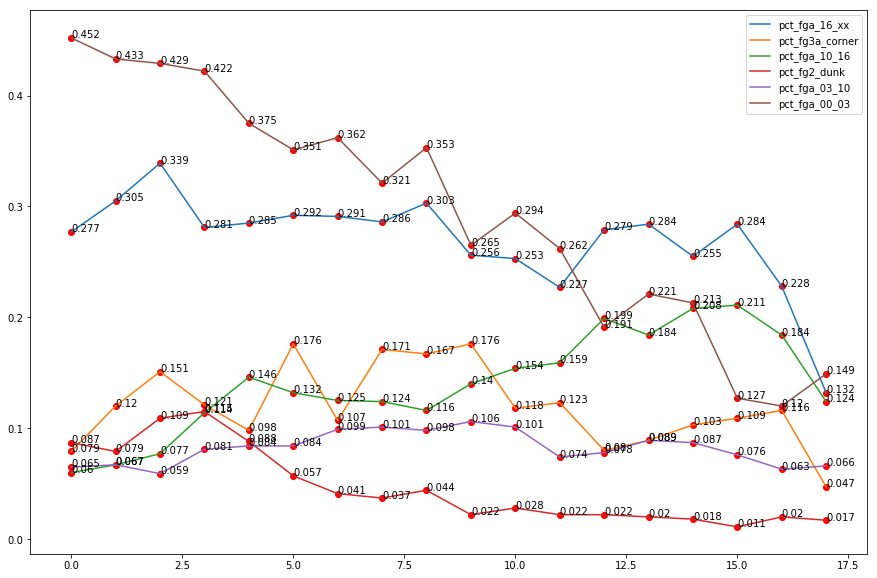

In [164]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for key in Me7o.keys():
    index = Me7o.index
    if key[0:3] == "pct":
        vals = list(map(lambda x: float(x), Me7o[key].values))
        i = list(map(lambda x: int(x), index))
        plt.plot(i,vals,label = key)
        plt.scatter(i,vals,color="#ff0000")
        
        for v in range(len(vals)):
            plt.annotate(vals[v],(i[v],vals[v]))
        

        
plt.legend()

In [208]:
B_Lo = Data.player("Brook Lopez").fetch()["all_shooting"].query("age != 'None'")

<status: 200>


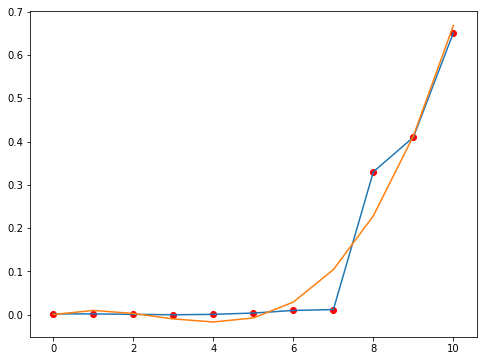

In [209]:
plt.figure(figsize=(8,6))
plt.plot(list(B_Lo.index), list(map(lambda x: float(x), B_Lo['fg3a_pct_fga'].values)))
plt.scatter(list(B_Lo.index), list(map(lambda x: float(x), B_Lo['fg3a_pct_fga'].values)),color="red")

poly = np.polyfit(list(B_Lo.index), list(map(lambda x: float(x), B_Lo['fg3a_pct_fga'].values)), 3)
p = np.poly1d(poly)

plt.plot(list(B_Lo.index), p(list(B_Lo.index)),label = "3rd degree polynomial fit")

In [211]:
B_Lo_adv = B_Lo = Data.player("Brook Lopez").fetch()["all_advanced"].query("age != 'None'")

<status: 200>


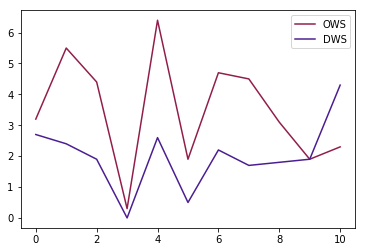

In [222]:
ows = list(map(lambda x: float(x), B_Lo_adv["ows"].values))
dws = list(map(lambda x: float(x), B_Lo_adv["dws"].values))

index = list(B_Lo_adv.index)

plt.plot(index,ows,color="#911e4a",label="OWS")
plt.plot(index,dws,color="#4a1e91",label="DWS")

plt.legend()